Code pour venir faire des stats de base comme par exemple std, mean , mediane ou meme volat du CVD ?
Ensuite faire des stats sur le pourcentage de chance d'avoir une bougie différente du delta et il ce passe quoi dans les 10 prochaines bougie ? c'est vraiment hsitoire de mettre le pied a l'étrier de venir faire des stats tout a fait basique sur ca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\Jordi\Desktop\ALGO\algo\aggregated_2023_04050607_600_ticks.csv")

signe_contraire
Delta Neg / Return Neg    12954
Delta Pos / Return Pos    11654
Delta Neg / Return Pos     2580
Delta Pos / Return Neg     2521
Name: count, dtype: int64


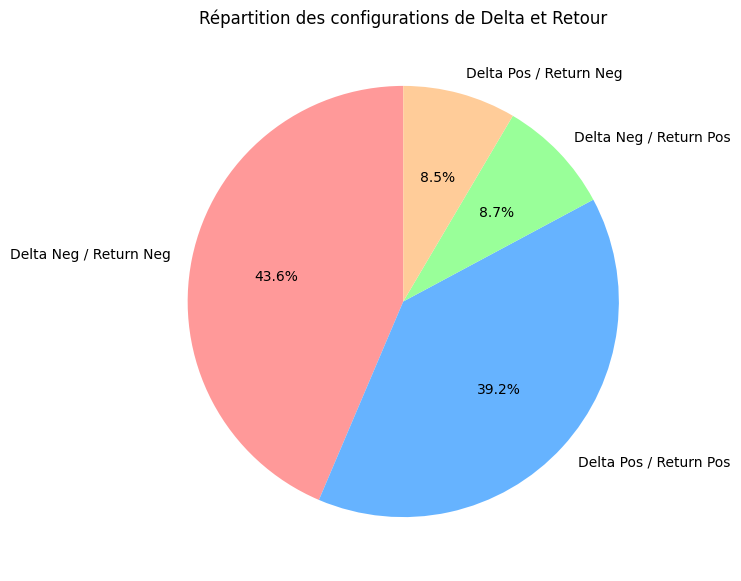

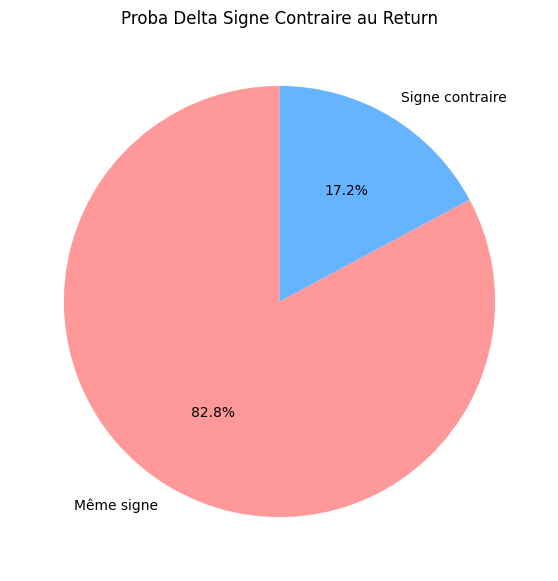

In [3]:
df['return'] = df['close'].pct_change()  

df.dropna(subset=['return'], inplace=True)


df['signe_contraire'] = np.where((df['delta'] > 0) & (df['return'] < 0), 'Delta Pos / Return Neg', 
                        np.where((df['delta'] < 0) & (df['return'] > 0), 'Delta Neg / Return Pos', 
                        np.where((df['delta'] > 0) & (df['return'] > 0), 'Delta Pos / Return Pos', 
                        'Delta Neg / Return Neg')))

counts = df['signe_contraire'].value_counts()


print(counts)


plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Répartition des configurations de Delta et Retour')
plt.show()

df['simple_contraire'] = np.where((df['delta'] > 0) & (df['return'] < 0), 'Signe contraire', 
                        np.where((df['delta'] < 0) & (df['return'] > 0), 'Signe contraire', 'Même signe'))

counts_simple = df['simple_contraire'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts_simple, labels=counts_simple.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Proba Delta Signe Contraire au Return')
plt.show()

Maintenant que on a les stats on va faire un truc assez simple et on va voir l'évolution du prix en suivant cette divergence dans les 10 bougie qui suivent



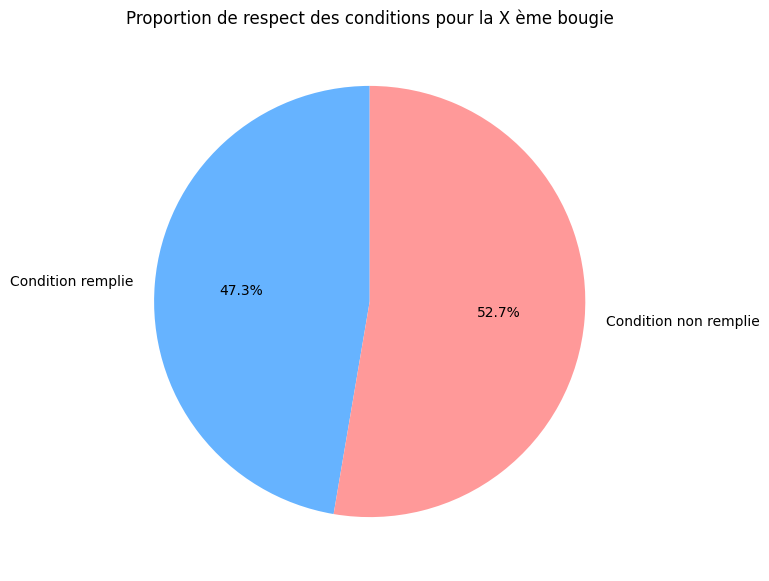

In [4]:
df_signe_contraire = df[(df['delta'] > 0) & (df['return'] < 0) | (df['delta'] < 0) & (df['return'] > 0)].copy()

conditions = []


for i in range(len(df_signe_contraire)):
    index_bougie = df_signe_contraire.index[i]
    
    prix_initial = df.loc[index_bougie, 'close']
    

    if index_bougie + 1 < len(df):
        prix_10e_bougie = df['close'].iloc[index_bougie + 1]
       
        if df.loc[index_bougie, 'delta'] > 0 and df.loc[index_bougie, 'return'] < 0:
            if prix_10e_bougie > prix_initial:
                conditions.append(1)  # Condition remplie (prix supérieur)
            else:
                conditions.append(0)  # Condition non remplie
        
        # Cas 2: Delta négatif et retour positif, on veut voir si le prix diminue après 10 bougies
        elif df.loc[index_bougie, 'delta'] < 0 and df.loc[index_bougie, 'return'] > 0:
            if prix_10e_bougie < prix_initial:
                conditions.append(1)  # Condition remplie (prix inférieur)
            else:
                conditions.append(0)  # Condition non remplie
    else:
      
        conditions.append(np.nan)


df_signe_contraire['condition_remplie'] = conditions


df_valid = df_signe_contraire.dropna(subset=['condition_remplie'])


nb_conditions_remplies = df_valid['condition_remplie'].sum()
total_cases = len(df_valid)

proba_conditions_remplies = (nb_conditions_remplies / total_cases) * 100
labels = ['Condition remplie', 'Condition non remplie']
sizes = [nb_conditions_remplies, total_cases - nb_conditions_remplies]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Proportion de respect des conditions pour la X ème bougie")
plt.show()


Ici on remarque que d'apres les stats que une divergence sur une seule bougie ne donne pas réellement d'edge de manière basique, c'est a dire vendre un delta neg / return pos et acheter un delta pos et une bougie rouge.
J'ai essayé de faire varier le parametre de bougie qui suit et on remarque que la proba reste du 1/2

Z score = 
$$
Z_t = \frac{X_t - \mu_t}{\sigma_t}
$$
$$
\mu_t = \alpha X_t + (1 - \alpha) \mu_{t-1}
$$
$$
\sigma_t^2 = \alpha (X_t - \mu_t)^2 + (1 - \alpha) \sigma_{t-1}^2
$$
$$
\sigma_t = \sqrt{\sigma_t^2}
$$
$$
\mu_t = Moyenne Exponentielle (EMA) pour la Moyenne
$$
$$
\sigma_t^2 = Variance Exponentielle :
$$
$$
\sigma_t = Écart Type Exponentiel
$$
$$
X_t = Représente-la-valeur-actuelle-de-la-variable

In [5]:
#Calcul du Z-score
alpha=0.1

df['EMA'] = df['close'].ewm(alpha=alpha, adjust=False).mean()
    

df['variance_EMA'] = 0.0
df.loc[0, 'variance_EMA'] = 0
    

for t in range(1, len(df)):
    df.loc[t, 'variance_EMA'] = alpha * (df.loc[t, 'close'] - df.loc[t, 'EMA'])**2 + (1 - alpha) * df.loc[t-1, 'variance_EMA']
    
df['sigma'] = np.sqrt(df['variance_EMA'])
    
df['Z_score'] = (df['close'] - df['EMA']) / df['sigma']


#calcul Z score pour le CVD



# Calcul de l'EMA pour le CVD
df['EMA_CVD'] = df['CVD'].ewm(alpha=alpha, adjust=False).mean()


df.loc[0, 'variance_EMA_CVD'] = 0


for t in range(1, len(df)):
    df.loc[t, 'variance_EMA_CVD'] = alpha * (df.loc[t, 'CVD'] - df.loc[t, 'EMA_CVD'])**2 + (1 - alpha) * df.loc[t-1, 'variance_EMA_CVD']



df['sigma_CVD'] = np.sqrt(df['variance_EMA_CVD'])


df['Z_score_CVD'] = (df['CVD'] - df['EMA_CVD']) / df['sigma_CVD']


print(df['variance_EMA_CVD'])


# Un Z score qui s'éloigne signifie que le prix ou le CVD s'éloigne de sa moyenne 




1             0.000000
2         19847.025000
3         49351.254750
4         97579.914098
5        129131.015344
             ...      
29706    486963.347302
29707    440636.548878
29708    399682.462410
29709    361594.013897
0             0.000000
Name: variance_EMA_CVD, Length: 29710, dtype: float64


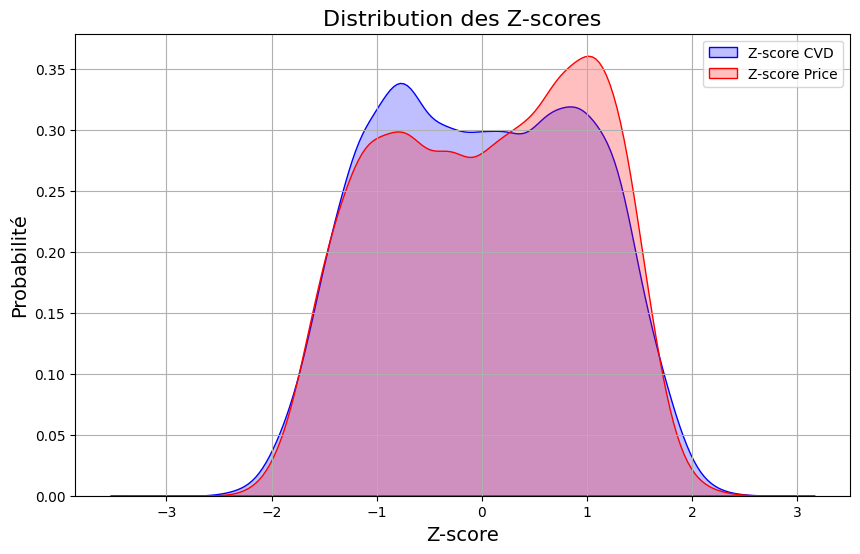

In [6]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df['Z_score_CVD'], color='blue', fill=True,label="Z-score CVD")
sns.kdeplot(df['Z_score'], color='red', fill=True,label="Z-score Price")

plt.title("Distribution des Z-scores", fontsize=16)
plt.xlabel("Z-score", fontsize=14)
plt.ylabel("Probabilité", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#Venir calculer la vitesse puis l'accélération


df['dt1'] = df['Z_score'] - df['Z_score'].shift(1)
#df['dt1'] = df['dt1'].abs()
df['dt2'] = df['dt1'] - df['dt1'].shift(1)

#df['dt2'] = df['dt2'].abs()

df['dt1_CVD'] = df['Z_score_CVD'].abs() - df['Z_score_CVD'].shift(1).abs()
df['dt2_CVD'] = df['dt1_CVD'] - df['dt1_CVD'].shift(1)




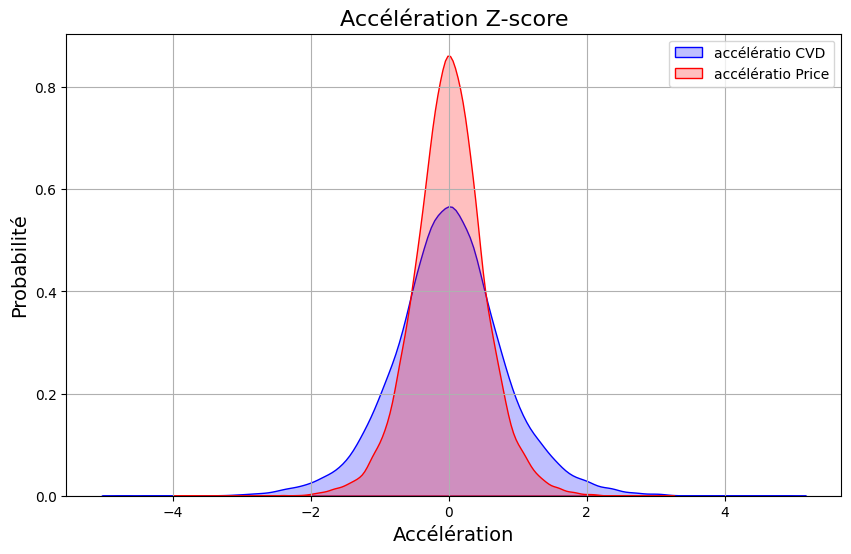

In [8]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df['dt2'], color='blue', fill=True,label="accélératio CVD")
sns.kdeplot(df['dt2_CVD'], color='red', fill=True,label="accélératio Price")

plt.title("Accélération Z-score", fontsize=16)
plt.xlabel("Accélération", fontsize=14)
plt.ylabel("Probabilité", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

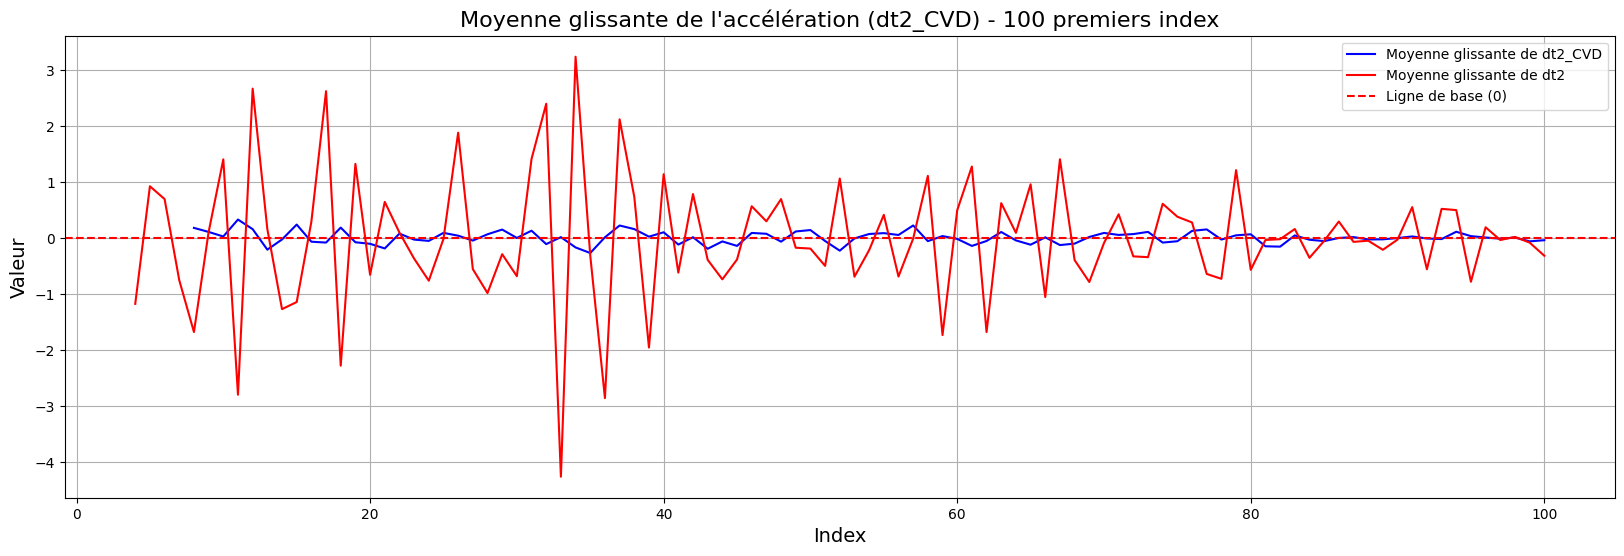

In [9]:

df['SMA_dt2_CVD'] = df['dt2_CVD'].rolling(window=5).mean()


df_100 = df.iloc[:100]

# Créer le graphique
plt.figure(figsize=(20, 6))

# Tracer la courbe de la moyenne glissante de dt2_CVD sur les 100 premiers index
plt.plot(df_100['SMA_dt2_CVD'], label='Moyenne glissante de dt2_CVD', color='blue')
plt.plot(df_100['dt2'], label='Moyenne glissante de dt2', color='red')

# Ajouter une ligne horizontale à zéro
plt.axhline(0, color='red', linestyle='--', label='Ligne de base (0)')

# Ajouter des titres et labels
plt.title("Moyenne glissante de l'accélération (dt2_CVD) - 100 premiers index", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Valeur", fontsize=14)

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()



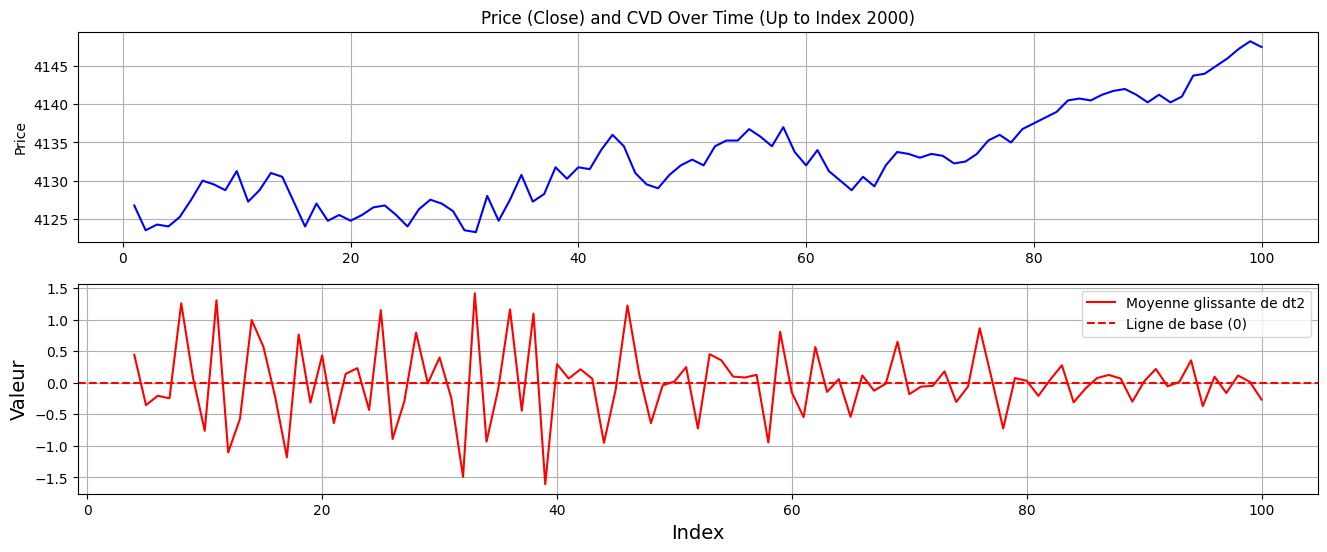

In [10]:
df_100 = df.iloc[:100]

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.plot(df_100.index, df_100['close'], label="Price (Close)", color="blue")
plt.title("Price (Close) and CVD Over Time (Up to Index 2000)")
plt.ylabel("Price")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_100['dt2_CVD'], label='Moyenne glissante de dt2', color='red')
plt.axhline(0, color='red', linestyle='--', label='Ligne de base (0)')

plt.xlabel("Index", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.legend()

plt.grid(True)
plt.show()

In [ ]:

#Coder des supports et quand le CVD accélère fort a la baisse alors tu vends 



### Formule de Min-Max Scaling :

La formule standard pour la mise à l'échelle min-max est la suivante :
$$

X' = \frac{X - X_{min}}{X_{max} - X_{min}}

$$

Où :
- \(X\) : La valeur initiale.
- \(X_{min}\) : La valeur minimale dans la série ou le dataset.
- \(X_{max}\) : La valeur maximale dans la série ou le dataset.
- \(X'\) : La nouvelle valeur mise à l'échelle dans la plage de 0 à 1.


1.Normalisation des prix ou indicateurs : En finance, les données peuvent varier sur des échelles très différentes, surtout lorsqu'on traite des prix de plusieurs actifs ou des indicateurs financiers. Le Min-Max Scaling permet de normaliser ces séries pour qu'elles soient comparables les unes avec les autres, en les mettant toutes sur la même échelle (typiquement entre 0 et 1).

2.Prétraitement pour les modèles de Machine Learning : Dans les modèles de machine learning, notamment en finance quantitative, la mise à l'échelle est essentielle. Les modèles basés sur les distances (comme les réseaux de neurones ou les SVM) sont très sensibles aux écarts d'échelle. Appliquer un Min-Max Scaling permet de garantir que les features sont sur la même échelle, évitant que certaines variables dominent les autres uniquement à cause de leur amplitude.

3.Faciliter les comparaisons : Si tu analyses différentes séries de données financières (comme des indices boursiers, des prix d'actifs, des volumes de trading), utiliser le Min-Max Scaling te permet de comparer visuellement ou analytiquement ces séries, même si elles ont des plages de valeurs très différentes.

In [24]:
#Min-Max Scaling



In [25]:
#Faire la corrélation de Pearson

In [26]:
#Corrélation de Spearman

In [27]:
#Mesure de l'Élasticité

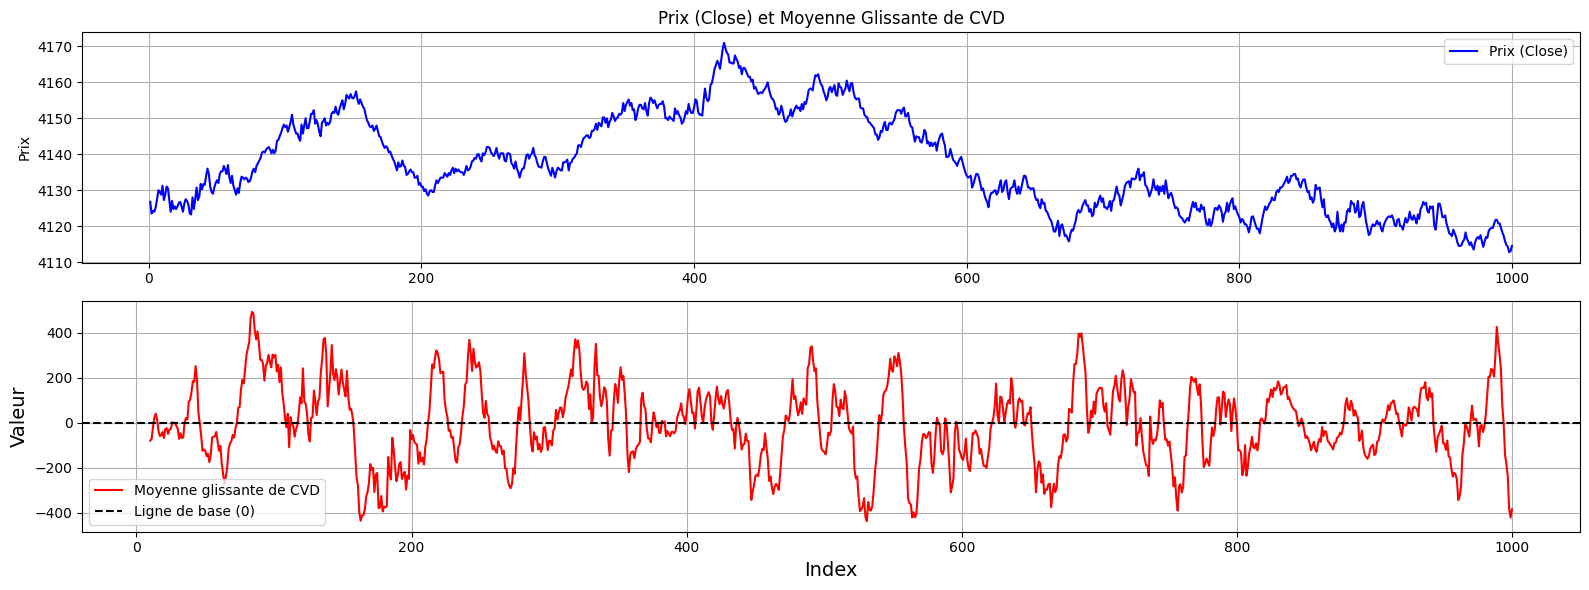

In [15]:
#Mean delta sur une fenetre glissante de 20

df['rolling_mean'] =  df['delta'].rolling(window=10).mean()

df_100 = df.iloc[:1000]


plt.figure(figsize=(16, 6))

# Premier sous-graphe : Prix de clôture
plt.subplot(2, 1, 1)
plt.plot(df_100.index, df_100['close'], label="Prix (Close)", color="blue")
plt.title("Prix (Close) et Moyenne Glissante de CVD")
plt.ylabel("Prix")
plt.grid(True)
plt.legend()

# Deuxième sous-graphe : Moyenne glissante de CVD
plt.subplot(2, 1, 2)
plt.plot(df_100['rolling_mean'], label='Moyenne glissante de CVD', color='red')
plt.axhline(0, color='black', linestyle='--', label='Ligne de base (0)')
plt.xlabel("Index", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.legend()
plt.grid(True)

# Ajustement de l'espacement
plt.tight_layout()
plt.show()

